In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Libraries

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 106 kB 7.6 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 287 kB 49.0 MB/s 


#Import all Required Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import re, itertools, json, os, random, contractions, nltk, warnings
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob as TB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from datetime import datetime
from bs4 import BeautifulSoup
from textblob import Word
# Essential imports

import numpy as np
import pandas as pd 
import re
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
import matplotlib.pyplot as plt

# Data Acquisition

In [ ]:
traindataset = pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/TrainingDataset/train_nykaa_review_sentiment.csv')
testdataset = pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/TrainingDataset/test_nykaa_review_sentiment.csv')
frames = [traindataset,testdataset]
alldataset = pd.concat(frames)

In [ ]:
traindataset.shape

(155544, 2)

In [ ]:
alldataset.dropna(inplace = True)
alldataset=alldataset.rename(columns={'content': 'reviews', 'sentiment_labels': 'sentiments'})
alldataset.head()

reviews sentiments
0                                  Nice shopping app   POSITIVE
1  Nykaa you yuyz are not giving my reward points...   NEGATIVE
2                                            Love it   POSITIVE
3                                  Is cod available?   NEGATIVE
4                                        Its awesome   POSITIVE

In [ ]:
alldatasetdl=alldataset

# Data Preprocessing

## Text Data Analysis

In [ ]:
def sentiment_analyzer(x):
    if x<0.3:
        return -1
    elif x>0.55:
        return 1
    else:
        return 0

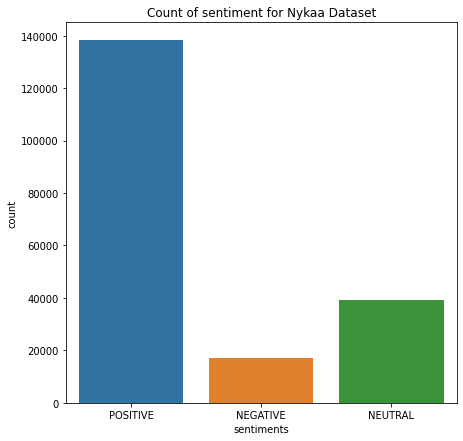

In [ ]:
plt.figure(figsize = (7,7))
plt.title('Count of sentiment for Nykaa Dataset')
sns.countplot(alldataset.sentiments)
plt.show()

In [ ]:
# to tackle first task lets define a useFul 
# Function
def WordCloudForsentiments (alldataset, sentiments):
    df =  (alldataset[alldataset['sentiments'] == sentiments]['reviews'])
    corpus = ''
    
    for mem in df:
        corpus += mem
    
    corpus = re.sub('READ MORE', '', corpus)
    wordcloud = WordCloud(width = 900, height = 800,background_color ='white',
                          stopwords = stopwords,  min_font_size = 10).generate(corpus)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.rcParams.update({'font.size': 25})
    plt.axis("off") 
    plt.title('Word Cloud:  ' + sentiments + ' Sentiment reviews')
    plt.tight_layout(pad = 0) 
  
    plt.show() 
    plt.figure(figsize=(12, 8))
    

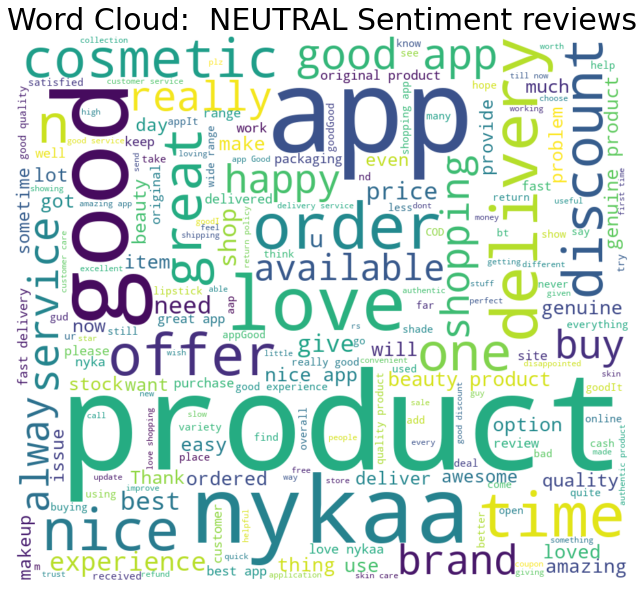

<Figure size 864x576 with 0 Axes>

In [ ]:
sentiments=['NEUTRAL','POSITIVE','NEGATIVE']
# word cloud for 1 star products
WordCloudForsentiments(alldataset,sentiments[0])

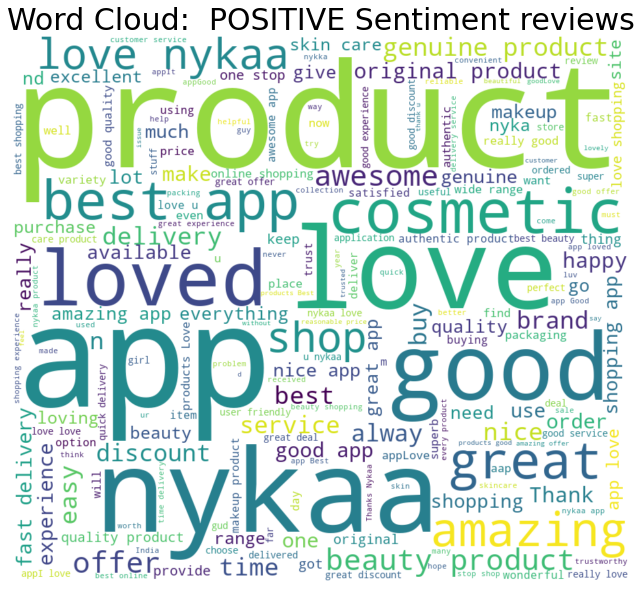

<Figure size 864x576 with 0 Axes>

In [ ]:
# word cloud for 2 positive product reviews
WordCloudForsentiments(alldataset, sentiments[1])

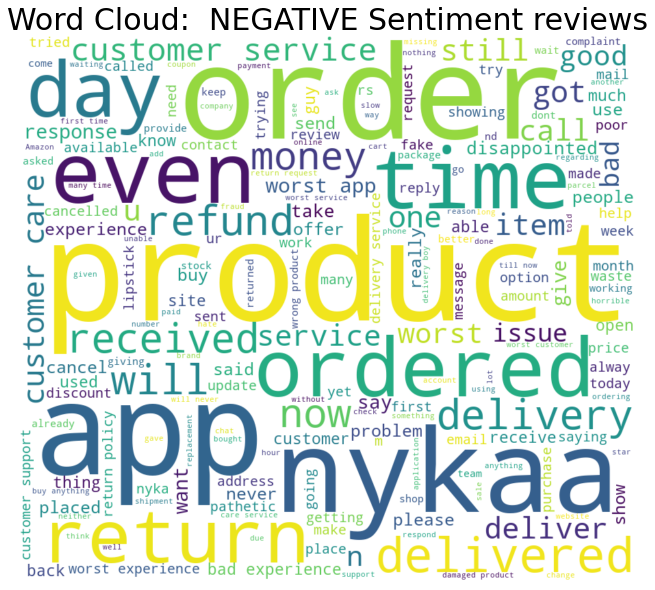

<Figure size 864x576 with 0 Axes>

In [ ]:
# word cloud for 3 negative product reviews
WordCloudForsentiments(alldataset, sentiments[2])

In [ ]:
import contractions
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [ ]:
alldataset.dropna(inplace = True)
alldataset = alldataset.reset_index(drop = True)

In [ ]:
alldataset.reviews = alldataset.reviews.map(lambda x: denoise_text(x))        
# alldataset.reviews = alldataset.reviews.map(lambda x: replace_contractions(x))
alldataset.reviews = alldataset.reviews.str.replace('[^\w\s]',' ')
alldataset.reviews = alldataset.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))

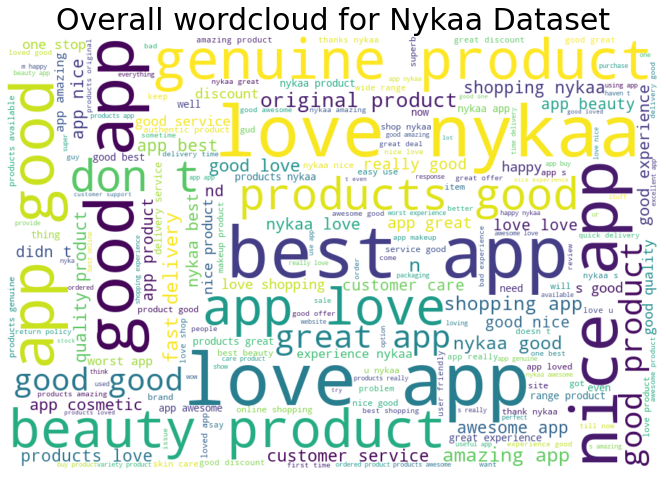

In [ ]:
stopset = stopwords
alldataset_words = ' '.join([text for text in alldataset.reviews])
alldataset_words = ' '.join([w for w in alldataset_words.split() if not w in stopset])
wordcloud = WordCloud(background_color = "white",width=900, height=600, random_state=21, max_font_size=100).generate(alldataset_words)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Overall wordcloud for Nykaa Dataset')
plt.axis('off')
plt.show()

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import contractions
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [ ]:
alldataset.dropna(inplace = True)
alldataset= alldataset.reset_index(drop = True)

In [ ]:
alldataset.reviews = alldataset.reviews.map(lambda x: denoise_text(x))        
alldataset.reviews = alldataset.reviews.map(lambda x: replace_contractions(x))
alldataset.reviews = alldataset.reviews.str.replace('[^\w\s]',' ')
alldataset.reviews = alldataset.reviews.apply(lambda x: " ".join(x.lower() for x in x.split()))

# Data Transformation

In [ ]:
## lets predict Product sentimentss 
## will be using mutliclass classification for 
## for our Purposue

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
text = alldataset['reviews']
label = alldataset['sentiments']

## Converting data to numpy array
## for ease of analysis

text = np.array(text)
labels = np.array(label)
le = preprocessing.LabelEncoder()
label=le.fit_transform(label)
## also labels are from 1-5
## tf expects 0-4
## hence this

## splitting to train and test sets
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size = 0.1, random_state = 42)
X_trainML, X_tesML, y_trainML, y_testML = train_test_split(text, labels, test_size = 0.1, random_state = 42)
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen = 50)
X_test = pad_sequences(X_test, maxlen = 50)
len(tokenizer.word_index)
epochs = 100
emb_dim = 50
batch_size = 256
n_most_common_words=10000



# Machine Learning Models

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mlresults(modelname , y_test,pred):
  accuracy = metrics.accuracy_score(y_testML,pred)
  confusion_matrix = metrics.confusion_matrix(y_test,pred)
  classification = metrics.classification_report(y_test,pred)
  print('============================== {} Model Test Results =============================='.format(modelname))
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()  

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, y_trainML)
knnpred =KNN_Classifier.predict(X_test)
mlresults('KNN' , y_testML,knnpred)

============================== KNN Model Test Results ==============================

Model Accuracy:
 0.6613176978861287

Confusion matrix:
 [[  549   259   933]
 [  215   622  3060]
 [  379  1739 11687]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.48      0.32      0.38      1741
     NEUTRAL       0.24      0.16      0.19      3897
    POSITIVE       0.75      0.85      0.79     13805

    accuracy                           0.66     19443
   macro avg       0.49      0.44      0.45     19443
weighted avg       0.62      0.66      0.64     19443




In [ ]:
# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier=LGR_Classifier.fit(X_train, y_trainML)
lgrpred =LGR_Classifier.predict(X_test)
mlresults('LGR' , y_testML,lgrpred)

============================== LGR Model Test Results ==============================

Model Accuracy:
 0.7230880008229182

Confusion matrix:
 [[  401    80  1260]
 [   96    26  3775]
 [  141    32 13632]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.63      0.23      0.34      1741
     NEUTRAL       0.19      0.01      0.01      3897
    POSITIVE       0.73      0.99      0.84     13805

    accuracy                           0.72     19443
   macro avg       0.52      0.41      0.40     19443
weighted avg       0.61      0.72      0.63     19443




In [ ]:
# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier = BNB_Classifier.fit(X_train, y_trainML)
BNBpred =BNB_Classifier.predict(X_test)
mlresults('BNB' , y_testML,BNBpred)

============================== BNB Model Test Results ==============================

Model Accuracy:
 0.6879082446124569

Confusion matrix:
 [[ 1041    40   660]
 [  506    97  3294]
 [ 1274   294 12237]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.60      0.46      1741
     NEUTRAL       0.23      0.02      0.04      3897
    POSITIVE       0.76      0.89      0.82     13805

    accuracy                           0.69     19443
   macro avg       0.45      0.50      0.44     19443
weighted avg       0.61      0.69      0.63     19443




In [ ]:
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier=DTC_Classifier.fit(X_train, y_trainML)
dtcpred =DTC_Classifier.predict(X_test)
mlresults('DTC' , y_testML,dtcpred)

============================== DTC Model Test Results ==============================

Model Accuracy:
 0.6739700663477859

Confusion matrix:
 [[  785   309   647]
 [  293   577  3027]
 [  555  1508 11742]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.48      0.45      0.47      1741
     NEUTRAL       0.24      0.15      0.18      3897
    POSITIVE       0.76      0.85      0.80     13805

    accuracy                           0.67     19443
   macro avg       0.49      0.48      0.48     19443
weighted avg       0.63      0.67      0.65     19443




In [ ]:
SVM_Classifier = SVC()
SVM_Classifier = SVM_Classifier.fit(X_train[:38886], y_trainML[:38886])
svmpred =SVM_Classifier.predict(X_test)
mlresults('SVM' , y_testML,svmpred)

============================== SVM Model Test Results ==============================

Model Accuracy:
 0.7298256441907113

Confusion matrix:
 [[  713     0  1028]
 [  200     0  3697]
 [  326     2 13477]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.58      0.41      0.48      1741
     NEUTRAL       0.00      0.00      0.00      3897
    POSITIVE       0.74      0.98      0.84     13805

    accuracy                           0.73     19443
   macro avg       0.44      0.46      0.44     19443
weighted avg       0.58      0.73      0.64     19443




In [ ]:
RandomForest_Classifier = RandomForestClassifier(n_estimators=800)
RandomForest_Classifier.fit(X_train, y_trainML)
rfpred =RandomForest_Classifier.predict(X_test)
mlresults('RF' , y_testML,rfpred)

============================== RF Model Test Results ==============================

Model Accuracy:
 0.7351746129712493

Confusion matrix:
 [[  861    32   848]
 [  204   150  3543]
 [  266   256 13283]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.65      0.49      0.56      1741
     NEUTRAL       0.34      0.04      0.07      3897
    POSITIVE       0.75      0.96      0.84     13805

    accuracy                           0.74     19443
   macro avg       0.58      0.50      0.49     19443
weighted avg       0.66      0.74      0.66     19443




In [ ]:
model1 = RandomForestClassifier()
model2 = KNeighborsClassifier()
model3 = LogisticRegression()
Voting = VotingClassifier(estimators=[('RF', model1 ), ('knn', model2),('lr',model3)], voting='hard')
Voting.fit(X_train, y_trainML)
vepred =Voting.predict(X_test)
mlresults('Voting' , y_testML,vepred)

============================== Voting Model Test Results ==============================

Model Accuracy:
 0.7337859383839942

Confusion matrix:
 [[  702    31  1008]
 [  193    95  3609]
 [  221   114 13470]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.63      0.40      0.49      1741
     NEUTRAL       0.40      0.02      0.05      3897
    POSITIVE       0.74      0.98      0.84     13805

    accuracy                           0.73     19443
   macro avg       0.59      0.47      0.46     19443
weighted avg       0.66      0.73      0.65     19443




In [ ]:
import joblib

def save_model(model,modelname):
  model_path = '/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/'
  modelfilename=modelname+'_model.sav'
  joblib.dump(model, model_path+modelfilename)

save_model(KNN_Classifier,'KNN_Classifier')
save_model(LGR_Classifier,'LGR_Classifier')
save_model(BNB_Classifier, 'BNB_Classifier')
save_model(DTC_Classifier , 'DTC_Classifier')
save_model(RandomForest_Classifier, 'RandomForest_Classifier')
save_model(SVM_Classifier, 'SVM_Classifier')
save_model(Voting, 'Voting_Classifier')

# Deep Learning

## LSTM

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
epochs = 100
emb_dim = 50
batch_size = 256
n_most_common_words=10000

In [ ]:
## defining model 
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Flatten())
model.add(Dense(10,activation = 'relu'))
model.add(Dense(3, activation='softmax'))
print(model.summary())
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

print(model.summary())

((174983, 50), (174983,), (19443, 50), (19443,))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
       

In [ ]:
X_train.shape

(174983, 50)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
## training model
from numpy import loadtxt
from tensorflow.keras.models import load_model 
#model = load_model('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/modellstm.h5')
retVal = model.fit(X_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(X_test,y_test))

Epoch 1/100
1234/5469 [=====>........................] - ETA: 5:20 - loss: 0.6380 - accuracy: 0.7511

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.grid(True)

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.plot(retVal.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/modellstm.h5")

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
 
# load model
model = load_model('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/modellstm.h5')
# summarize model.
model.summary()
# evaluate the model
score = model.evaluate(X_test,y_test, verbose=0)
Testresults= model.predict(X_test)
import pandas as pd

print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [ ]:
import pickle

with open('//content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [ ]:
from tables import index
df = pd.DataFrame(Testresults,columns=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
a = df.iloc[0]
result = a.idxmax()
print('Sentiment :',result)

## Convolutional Neural Network

In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
#os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [ ]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [ ]:
MAX_SEQUENCE_LENGTH = 50
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
# reading data
traindataset = pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/TrainingDataset/test_nykaa_review_sentiment.csv')
testdataset = pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/TrainingDataset/train_nykaa_review_sentiment.csv')
frames = [traindataset,testdataset]
df = pd.concat(frames)
df = df.dropna()
df.head()
df.dropna(inplace = True)
df= df.rename(columns={'content': 'reviews', 'sentiment_labels': 'Sentiment'})
df.head()

In [ ]:
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Sentiment'])))

In [ ]:
df.head()

In [ ]:
targetnum=np.unique(df['Sentiment'])
targetnum_to_id = dict((note, number) for number, note in enumerate(targetnum))

def fun(i):
    return targetnum_to_id[i]

df['Sentiment']=df['Sentiment'].apply(fun)

In [ ]:
texts = []
labels = []


for idx in range(df.reviews.shape[0]):
    text = BeautifulSoup(df.reviews[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['Sentiment']:
    labels.append(idx)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

In [ ]:
from tensorflow.keras.utils import pad_sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/EmbeddedWords/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_pool1 = Dropout(0.2)(l_pool1)
l_cov2 = Conv1D(64, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_pool2 = Dropout(0.2)(l_pool2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(10, activation='relu')(l_flat)
preds = Dense(len(targetnum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/bestcnn_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
from numpy import loadtxt
from tensorflow.keras.models import load_model 

Cnn_1st=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100, batch_size=32,callbacks=[es,mc])

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/modelcnn.h5")

In [ ]:
Cnn_1st.history

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(Cnn_1st.history['acc'], label = 'training_accuracy')
plt.plot(Cnn_1st.history['val_acc'], label = 'val_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
fig1 = plt.figure()
plt.plot(Cnn_1st.history['loss'],'r',linewidth=3.0)
plt.plot(Cnn_1st.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

# Multimodels STV Algorithm

In [ ]:
!pip install pyrankvote

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib
from numpy import loadtxt
from tensorflow.keras.models import load_model

BNB_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/BNB_Classifier_model.sav', 'rb'))
DTC_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/DTC_Classifier_model.sav', 'rb'))
KNN_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/KNN_Classifier_model.sav', 'rb'))
LGR_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/LGR_Classifier_model.sav', 'rb'))
SVM_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/SVM_Classifier_model.sav', 'rb'))
RandomForest_Classifier= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/RandomForest_Classifier_model.sav', 'rb'))
Voting= joblib.load(open('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/Voting_Classifier_model.sav', 'rb'))
CNN_model = load_model('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/CNN_model.h5')
LSTM_model = load_model('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model/LSTM_model.h5')

In [ ]:
models = []
models.append(('BNB_Classifier', BNB_Classifier))
models.append(('DTC_Classifier', DTC_Classifier))
models.append(('KNN_Classifier', KNN_Classifier))
models.append(('LGR_Classifier', LGR_Classifier))
models.append(('RandomForest_Classifier', RandomForest_Classifier))
models.append(('SVM_Classifier', SVM_Classifier))
models.append(('Voting_Classifier', Voting))
models.append(('CNN', CNN_model))
models.append(('LSTM',LSTM_model ))

In [ ]:
selectedmodels = []
selectedmodels.append(('DTC_Classifier', DTC_Classifier))
selectedmodels.append(('RandomForest_Classifier', RandomForest_Classifier))
selectedmodels.append(('Voting_Classifier', Voting))
selectedmodels.append(('CNN', CNN_model))
selectedmodels.append(('LSTM',LSTM_model ))

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from numpy import loadtxt
from keras.models import load_model
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pickle

def loadtokenizer(basedir):
	with open(os.path.join(basedir, 'tokenizer.pickle'), 'rb') as handle:
		return pickle.load(handle)

import contractions
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

def predictsentiment(model,comment,dir,modelname):
 basedir = os.path.abspath(dir)
 loaded_tokenizer=loadtokenizer(basedir)
 comment = denoise_text(comment)
 comment= replace_contractions(comment)
 comment = comment.replace('[^\w\s]',' ')
 comment= comment.lower()
 comment= comment.split(' ')
 seq = loaded_tokenizer.texts_to_sequences(comment)
 max_len=50
 padded = pad_sequences(seq, maxlen=max_len)
 if modelname == 'CNN' or modelname == 'LSTM':
   model = model
   # model.summary()
   Testresults = model.predict(padded)
   df = pd.DataFrame(Testresults, columns=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
   columns  = df.columns
   columnslist=[]
   dfs = df
   for i in range(0,3):
     c = dfs.iloc[0]
     val = c.idxmax()
     columnslist.append(val)
     dfs= dfs.drop([val], axis=1)
   a = df.iloc[0]
   index = a.idxmax()
   return columnslist
   # print('Sentiments :', result)
 else:
   model= model
   Testresults = model.predict(padded)
   return [Testresults[0]]
   # print('Sentiments :', result)


In [ ]:
predictsentiment(BNB_Classifier,'average','/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model','BNB_Classifier')

['POSITIVE']

In [ ]:
import pandas as pd
testdataset=pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Dataset/TestDataset/testfile.csv')
testdataset

Unnamed: 0                                            Reviews Sentiments
0             1                                               ðŸ‘ŒðŸ‘ŒðŸ‘ŒðŸ‘Œ   POSITIVE
1             2                                               Good   POSITIVE
2             3                  All items and brands at one place   POSITIVE
3             4  A app in which u can find most of the makeup p...   POSITIVE
4             5  Just love this app... It has made life a littl...   POSITIVE
..          ...                                                ...        ...
763        1059                                         excellenct   POSITIVE
764        1061  Brilliant app, brilliant store and wonderful e...   POSITIVE
765        1062          I love nykaa products this app is so cool   POSITIVE
766        1065                                          EXCELLENT   POSITIVE
767        1067  I love nykaa,I only shop from here only and hi...   POSITIVE

[768 rows x 3 columns]

In [ ]:
import pyrankvote
from pyrankvote import Candidate, Ballot
import pandas as pd

results=pd.DataFrame(columns=['Review','Targeted Sentiment','Naive Baye Classifier', 'Decision Tree Classifier', 'KNeighbors Classifier','Logistic Regression','Random Forest Classifier','Support Vector Machine','Voting Classifier','Convolutional Neural Network','Long short term Memory Network','STVEnsemble'])
lablesclass= np.unique(testdataset['Sentiments'])
negative = Candidate(lablesclass[0])
neutral = Candidate(lablesclass[1])
positive = Candidate(lablesclass[2])

candidates = [negative, neutral, positive]
for col in range(0,len(testdataset)):
  ballots=[]
  votes=[]
  votes.append(testdataset['Reviews'][col])
  votes.append(testdataset['Sentiments'][col])
  for i, v in models:
    vote= predictsentiment(v,testdataset['Reviews'][col],'/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/model',i)
    # print(vote)
    rankedcandidate =[]
    for j in vote:
      rankedcandidate.append(Candidate(j))
    a=Ballot(ranked_candidates=rankedcandidate)
    ballots.append(a)
    votes.append(vote[0])
  election_result = pyrankvote.single_transferable_vote(candidates, ballots, pick_random_if_blank=True,number_of_seats=1)
  winners = election_result.get_winners()
  print(winners)
  print(election_result)
  votes.append(str(winners[0]))
  results.loc[col] =votes

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
[<Candidate('POSITIVE')>]
FINAL RESULT
Candidate      Votes  Status
-----------  -------  --------
POSITIVE           9  Elected
NEUTRAL            0  Rejected
NEGATIVE           0  Rejected

2/2 [==============================] - 0s 15ms/step
[<Candidate('POSITIVE')>]
FINAL RESULT
Candidate      Votes  Status
-----------  -------  --------
POSITIVE           7  Elected
NEGATIVE           2  Rejected
NEUTRAL            0  Rejected

1/1 [==============================] - 0s 23ms/step
[<Candidate('POSITIVE')>]
FINAL RESULT
Candidate      Votes  Status
-----------  -------  --------
POSITIVE           9  Elected
NEUTRAL            0  Rejected
NEGATIVE           0  Rejected

1/1 [==============================] - 0s 25ms/step
[<Candidate('POSITIVE')>]
FINAL RESULT
Candidate      Votes  Status
-----------  -------  --------
POSITIVE           9  Elected
NEUTRAL            0  Rejected
NEGAT

In [ ]:
results

Review Targeted Sentiment  \
0                                                 ðŸ‘ŒðŸ‘ŒðŸ‘ŒðŸ‘Œ           POSITIVE   
1                                                 Good           POSITIVE   
2                    All items and brands at one place           POSITIVE   
3    A app in which u can find most of the makeup p...           POSITIVE   
4    Just love this app... It has made life a littl...           POSITIVE   
..                                                 ...                ...   
763                                         excellenct           POSITIVE   
764  Brilliant app, brilliant store and wonderful e...           POSITIVE   
765          I love nykaa products this app is so cool           POSITIVE   
766                                          EXCELLENT           POSITIVE   
767  I love nykaa,I only shop from here only and hi...           POSITIVE   

    Naive Baye Classifier Decision Tree Classifier KNeighbors Classifier  \
0                POSITIVE                 POSITIVE               NEUTRAL   
1                POSITIVE                 POSITIVE              POSITIVE   
2                POSITIVE                 POSITIVE              POSITIVE   
3                POSITIVE                  NEUTRAL               NEUTRAL   
4                POSITIVE                 POSITIVE              POSITIVE   
..                    ...                      ...                   ...   
763              POSITIVE                 POSITIVE               NEUTRAL   
764              POSITIVE                 POSITIVE              POSITIVE   
765              POSITIVE                 POSITIVE              POSITIVE   
766              POSITIVE                 POSITIVE              POSITIVE   
767              POSITIVE                 POSITIVE              POSITIVE   

    Logistic Regression Random Forest Classifier Support Vector Machine  \
0              POSITIVE                 POSITIVE               POSITIVE   
1              POSITIVE                 POSITIVE               POSITIVE   
2              POSITIVE                 POSITIVE               POSITIVE   
3              POSITIVE                  NEUTRAL               POSITIVE   
4              POSITIVE                 POSITIVE               POSITIVE   
..                  ...                      ...                    ...   
763            POSITIVE                 POSITIVE               POSITIVE   
764            POSITIVE                 POSITIVE               POSITIVE   
765            POSITIVE                 POSITIVE               POSITIVE   
766            POSITIVE                 POSITIVE               POSITIVE   
767            POSITIVE                 POSITIVE               POSITIVE   

    Voting Classifier Convolutional Neural Network  \
0            POSITIVE                     POSITIVE   
1            POSITIVE                     POSITIVE   
2            POSITIVE                     POSITIVE   
3             NEUTRAL                     POSITIVE   
4            POSITIVE                     POSITIVE   
..                ...                          ...   
763          POSITIVE                     POSITIVE   
764          POSITIVE                     POSITIVE   
765          POSITIVE                     POSITIVE   
766          POSITIVE                     POSITIVE   
767          POSITIVE                     POSITIVE   

    Long short term Memory Network STVEnsemble  
0                         POSITIVE    POSITIVE  
1                         POSITIVE    POSITIVE  
2                         POSITIVE    POSITIVE  
3                         POSITIVE    POSITIVE  
4                         POSITIVE    POSITIVE  
..                             ...         ...  
763                       POSITIVE    POSITIVE  
764                       POSITIVE    POSITIVE  
765                       POSITIVE    POSITIVE  
766                       POSITIVE    POSITIVE  
767                       POSITIVE    POSITIVE  

[768 rows x 12 columns]

In [ ]:
results.to_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Results/results.csv')

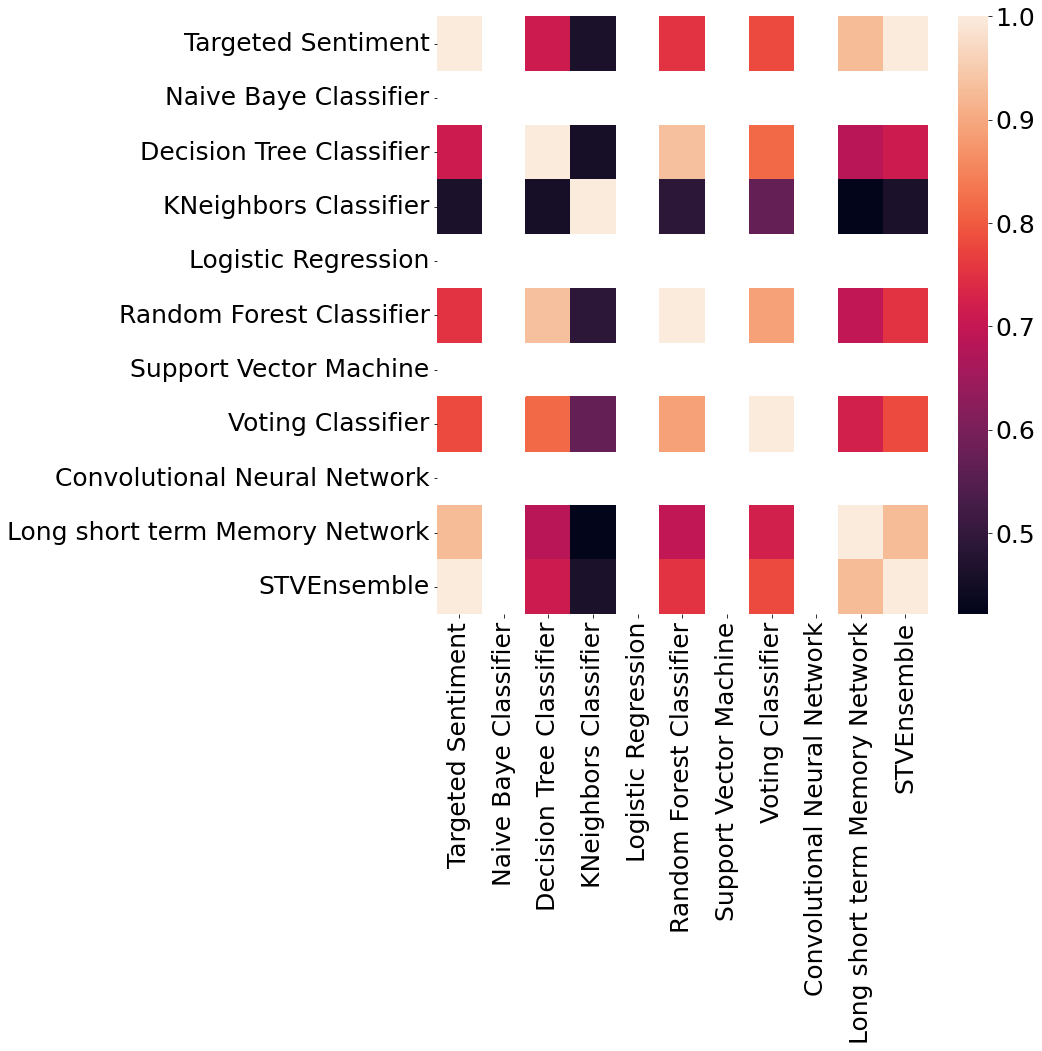

Most Correlated: Targeted Sentiment                1.000000
Decision Tree Classifier          0.712266
KNeighbors Classifier             0.462646
Random Forest Classifier          0.753420
Voting Classifier                 0.781353
Long short term Memory Network    0.927145
STVEnsemble                       1.000000
Name: Targeted Sentiment, dtype: float64


In [ ]:
import pandas as pd
from seaborn import heatmap
from sklearn.preprocessing import LabelEncoder
resultscrs=pd.read_csv('/content/drive/MyDrive/Project/CustomerReview_Sentiments_Anlysis/Results/results.csv')
le = LabelEncoder()
data = {'Targeted Sentiment': le.fit_transform(resultscrs['Targeted Sentiment'].tolist()),
        'Naive Baye Classifier': le.fit_transform(resultscrs['Naive Baye Classifier'].tolist()),
        'Decision Tree Classifier': le.fit_transform(resultscrs['Decision Tree Classifier'].tolist()),
        'KNeighbors Classifier': le.fit_transform(resultscrs['KNeighbors Classifier'].tolist()),
        'Logistic Regression': le.fit_transform(resultscrs['Logistic Regression'].tolist()),
        'Random Forest Classifier': le.fit_transform(resultscrs['Random Forest Classifier'].tolist()),
        'Support Vector Machine': le.fit_transform(resultscrs['Support Vector Machine'].tolist()),
        'Voting Classifier': le.fit_transform(resultscrs['Voting Classifier'].tolist()),
        'Convolutional Neural Network': le.fit_transform(resultscrs['Convolutional Neural Network'].tolist()),
        'Long short term Memory Network': le.fit_transform(resultscrs['Long short term Memory Network'].tolist()),
        'STVEnsemble': le.fit_transform(resultscrs['STVEnsemble'].tolist())
         }
resultscrs=pd.DataFrame(data)
resultscrs = resultscrs.fillna(0)
cor_matrix = resultscrs.corr()
cor_matrix.head()
fig, ax = plt.subplots(figsize=(11, 11))
ax = heatmap(cor_matrix)
plt.show()
# Correlation with output variable
cor_target = abs(cor_matrix['Targeted Sentiment'])
# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.12]
print("Most Correlated:",relevant_features)

# EVALUATE MODELS

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
def mlresults(modelname , y_test,pred):
  accuracy = metrics.accuracy_score(y_test,pred)
  confusion_matrix = metrics.confusion_matrix(y_test,pred)
  classification = metrics.classification_report(y_test,pred)
  le = preprocessing.LabelEncoder()
  target=le.fit_transform(y_test)
  predicted = le.fit_transform(pred)
  accuracy = metrics.accuracy_score(target, predicted)
  mse=mean_squared_error(target, predicted)
  rs=r2_score(target, predicted)
  print('============================== {} Model Test Results =============================='.format(modelname))
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print()
  print("Confusion matrix:" "\n", confusion_matrix)
  print()
  print("Classification report:" "\n", classification) 
  print()
  print ("Model Accuracy:" "\n", accuracy)
  print("Mean squared error: ", mse)
  print('Variance score: %.2f' % rs)

  return accuracy,mse,rs

In [ ]:
accuracy_score=list()
mse_values=list()
variance_score=list()
resultscore=pd.DataFrame(columns=['Model','Accuracy','Mean Squar Error','Root2 Score'])
target= results['Targeted Sentiment']
modelnames=results.columns[2:]
for c in range(0,len(modelnames)):
  modelname=modelnames[c]
  accuracy,mse,rs=mlresults(modelname, target,results[modelname])  
  accuracy_score.append(accuracy)
  mse_values.append(mse)
  variance_score.append(rs)
  resultscore.loc[c] =[modelname,accuracy,mse,rs]

============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.015625

Confusion matrix:
 [[  0   0  12]
 [  0   0   2]
 [  0   0 754]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00        12
     NEUTRAL       0.00      0.00      0.00         2
    POSITIVE       0.98      1.00      0.99       754

    accuracy                           0.98       768
   macro avg       0.33      0.33      0.33       768
weighted avg       0.96      0.98      0.97       768


Model Accuracy:
 0.015625
Mean squared error:  3.9296875
Variance score: -60.44
============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9661458333333334

Confusion matrix:
 [[ 12   0   0]
 [  0   2   0]
 [  7  19 728]]

Classification report:
               precision    recall  f1-score   support

    NEGATIVE       0.63     

In [ ]:
resultscore

Model  Accuracy  Mean Squar Error  Root2 Score
0           Naive Baye Classifier  0.015625          3.929688   -60.441629
1        Decision Tree Classifier  0.966146          0.061198     0.043156
2           KNeighbors Classifier  0.819010          0.227865    -2.562719
3             Logistic Regression  0.015625          3.929688   -60.441629
4        Random Forest Classifier  0.971354          0.048177     0.246739
5          Support Vector Machine  0.015625          3.929688   -60.441629
6               Voting Classifier  0.983073          0.040365     0.368890
7    Convolutional Neural Network  0.015625          3.929688   -60.441629
8  Long short term Memory Network  0.997396          0.010417     0.837133
9                     STVEnsemble  1.000000          0.000000     1.000000

### Function for genesentiments the graph

In [ ]:
def generate_plot(title, ticks, dataset, color_number):
    colors = ["slateblue", "mediumseagreen", "tomato"]
    plt.figure(figsize=(15, 6))
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.xticks(np.arange(len(ticks)), ticks, fontsize=10, rotation=30)
    plt.title(title, fontsize = 22)
    plt.bar(ticks, dataset, linewidth=1.2, color=colors[color_number])

### Accuracy graph

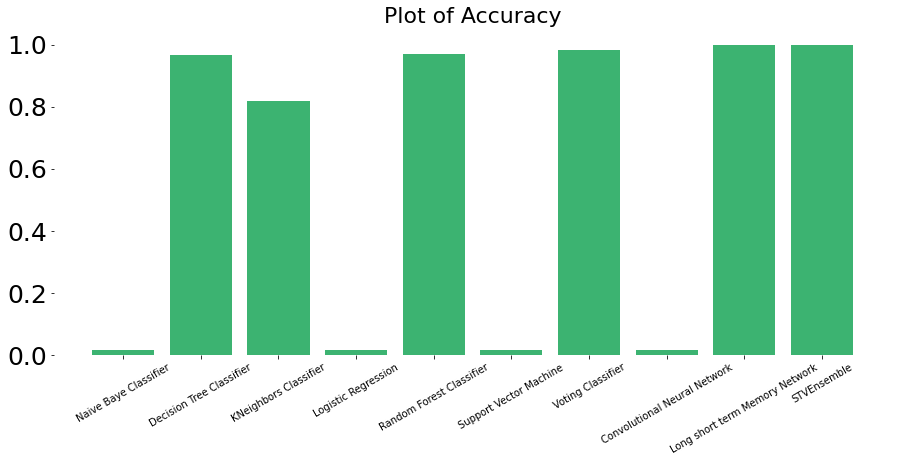

In [ ]:
ticks = modelnames
generate_plot("Plot of Accuracy", ticks, accuracy_score, 1)

### Mean squared error graph

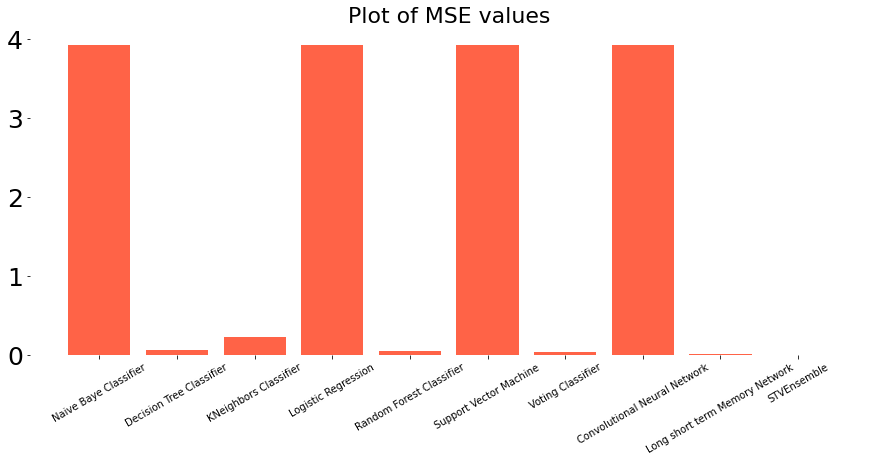

In [ ]:
ticks = modelnames
generate_plot("Plot of MSE values", ticks, mse_values, 2)

### Variance score graph

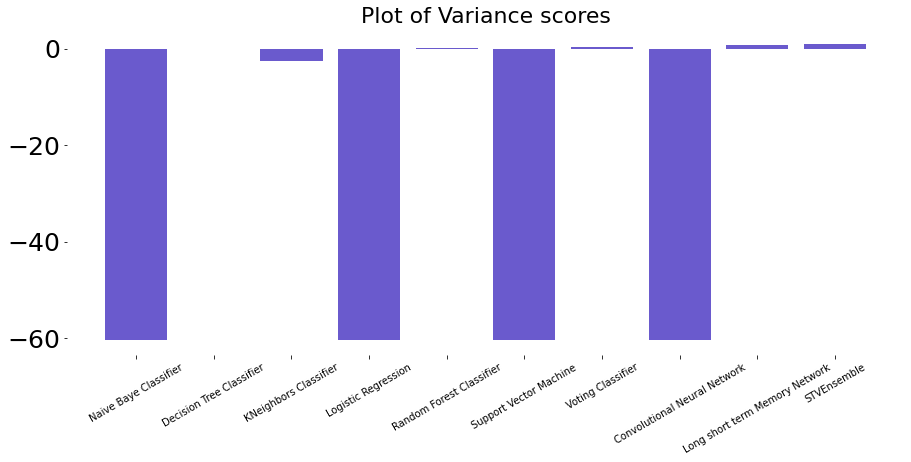

In [ ]:
ticks = modelnames
generate_plot("Plot of Variance scores", ticks, variance_score,0)

In [ ]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)
# Logistic regression
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_test=le.fit_transform(Y_test)
classes= list(le.classes_)
y_pred_prob_lr = BNB_Classifier.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(Y_test, y_pred_prob_lr)

# SVM with rbf
y_pred_prob_SVMrbf = DTC_Classifier.predict_proba(X_test)[:,1]
fpr_SVMrbf, tpr_SVMrbf, thresholds_SVMrbf = roc_curve(Y_test, y_pred_prob_SVMrbf)
roc_auc_SVMrbf = auc(fpr_SVMrbf, tpr_SVMrbf)
precision_SVMrbf, recall_SVMrbf, th_SVMrbf = precision_recall_curve(Y_test, y_pred_prob_SVMrbf)

# SVM with linear
y_pred_prob_SVMlinear = KNN_Classifier.predict_proba(X_test)[:,1]
fpr_SVMlinear, tpr_SVMlinear, thresholds_SVMlinear = roc_curve(Y_test, y_pred_prob_SVMlinear)
roc_auc_SVMlinear = auc(fpr_SVMlinear, tpr_SVMlinear)
precision_SVMlinear, recall_SVMlinear, th_SVMlinear = precision_recall_curve(Y_test, y_pred_prob_SVMlinear)

# KNN
y_pred_prob_KNN = LGR_Classifier.predict_proba(X_test)[:,1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(Y_test, y_pred_prob_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
precision_KNN, recall_KNN, th_KNN = precision_recall_curve(Y_test, y_pred_prob_KNN)


# Decision Tree
y_pred_prob_Tree = DTC_Classifier.predict_proba(X_test)[:,1]
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(Y_test, y_pred_prob_Tree)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(Y_test, y_pred_prob_Tree)

# Random forest
y_pred_prob_rf = KNN_Classifier.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, th_rf = precision_recall_curve(Y_test, y_pred_prob_rf)


# Naive Bayes

y_pred_prob_nb = Genbagging.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(Y_test, y_pred_prob_nb)

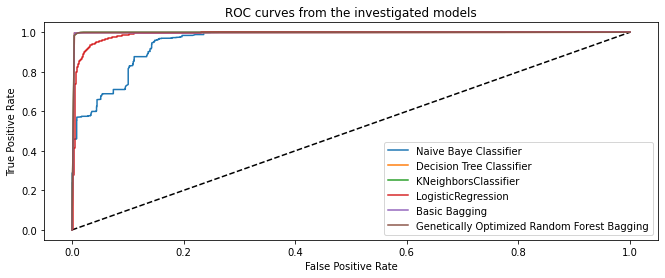

In [ ]:
ticks = ['Naive Baye Classifier','Decision Tree Classifier', 'KNeighborsClassifier','LogisticRegression','Basic Bagging','Genetically Optimized Random Forest Bagging']
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label=ticks[0] % roc_auc_lr)
plt.plot(fpr_SVMrbf, tpr_SVMrbf, label=ticks[1] % roc_auc_SVMrbf)
plt.plot(fpr_SVMlinear, tpr_SVMlinear, label=ticks[2] % roc_auc_SVMlinear)
plt.plot(fpr_KNN, tpr_KNN, label=ticks[3] % roc_auc_KNN)
plt.plot(fpr_Tree, tpr_Tree, label=ticks[4] % roc_auc_Tree)
plt.plot(fpr_rf, tpr_rf, label=ticks[5] % roc_auc_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()